# Deep Learning for Time Series Store forecast 
* By Alex Dance https://www.linkedin.com/in/alex-dance/
* This notebook is one of several notebooks for a project to improve store and product forecasts
1.	EDA – Exploratory Data Analysis – includes working with annual forecasts
2.	Main Modelling
3.	XG Boost modelling by Month
4.	Weighted average
5.	ARIMA – Month and Other Modelling
6.	Deep Learning


Useful is https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams


In [3]:
class color:  # Testing to make the heading look a liitle more impressive
   BOLD = '\033[1m'

In [4]:
from sklearn.metrics import mean_squared_error , mean_absolute_error

In [5]:
df = pd.read_csv(r'C:/Users/alexd/Alex Folder 1/Capstone - Store Forecast/train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Getting Data Ready

In [6]:
df['date'] =  pd.to_datetime(df['date'])

In [7]:
df = df.set_index('date')

In [8]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [9]:
df_1_1 = df[(df.store==1) & (df.item==1)] 

In [10]:
Deep1_all = df_1_1.resample('D')['sales'].sum()

In [11]:
#Deep1_all = df.resample('D')['sales'].sum()  # this is of doing the forecast on the total dataset by day

In [12]:
Deep1_all.head()

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Freq: D, Name: sales, dtype: int64

# The next few lines are to ensure can match the index to the date so can compare the predictions with an actual date

In [13]:
Deep1_all_With_index = Deep1_all.copy()

In [14]:
Deep1_all_With_index =Deep1_all_With_index.reset_index()

In [15]:
#Deep1_all_With_index.tail()

In [16]:
Deep1_all_With_index.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [17]:
Deep1 = Deep1_all_With_index.drop(['date'], axis = 1)

In [18]:
Deep1['sales'] = Deep1['sales'].astype('float32')

In [19]:
Deep1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1826 non-null   float32
dtypes: float32(1)
memory usage: 7.3 KB


In [20]:
values = Deep1.values

In [21]:
print(values)

[[13.]
 [11.]
 [14.]
 ...
 [15.]
 [27.]
 [23.]]


In [22]:
values = values.astype('float32')

In [23]:
Deep1.shape

(1826, 1)

In [24]:
train_size = int(len(Deep1) -376) # This is 366 days of the year + 10 days of extra data beforehand
test_size = len(Deep1) - train_size
train, test = Deep1.iloc[0:train_size], Deep1.iloc[train_size:len(Deep1)]
print(len(train), len(test))

1450 376


In [25]:
print(test)

      sales
1450   12.0
1451   20.0
1452   21.0
1453   13.0
1454   20.0
...     ...
1821   14.0
1822   19.0
1823   15.0
1824   27.0
1825   23.0

[376 rows x 1 columns]


In [26]:
print(train)

      sales
0      13.0
1      11.0
2      14.0
3      13.0
4      10.0
...     ...
1445   15.0
1446   19.0
1447   22.0
1448   17.0
1449   18.0

[1450 rows x 1 columns]


In [27]:
#train_c['sales'] = float(train_c['sales'])

In [28]:
train.head()

,sales
0,13.0
1,11.0
2,14.0
3,13.0
4,10.0


In [29]:
# One of the most difficult parts of Deep Learning modelling is to get the dataset in the right format 
# This function completes that proces

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
        #print(Xs[-1], ys[-1])  
    return np.array(Xs), np.array(ys)

In [30]:
test.shape

(376, 1)

In [31]:
# These next few lines are about getting the data ready for modelling
time_steps = 10

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.sales, time_steps)

#X_train_c, y_train_c = create_dataset(X_train_c_a, y_train_c_a, time_steps)
X_test, y_test = create_dataset(test, test.sales, time_steps)



In [32]:
print(X_train.shape, y_train.shape)
# Note the 3 dimensional shape

(1440, 10, 1) (1440,)


In [33]:
len(X_test)


366

In [34]:
# Try2
deep_model = keras.Sequential()
deep_model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
deep_model.add(keras.layers.Dense(units=2))
deep_model.add(keras.layers.Dense(units=1))

deep_model.compile(
  loss='mse',
  optimizer=keras.optimizers.Adam(0.001)) # was 0.001

In [35]:
history = deep_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30
81/81 [==============================] - 2s 21ms/step - loss: 73.9914 - val_loss: 37.2430
Epoch 2/30
81/81 [==============================] - 1s 12ms/step - loss: 44.1563 - val_loss: 36.7722
Epoch 3/30
81/81 [==============================] - 1s 10ms/step - loss: 42.1997 - val_loss: 35.8956
Epoch 4/30
81/81 [==============================] - 1s 11ms/step - loss: 39.7363 - val_loss: 34.0288
Epoch 5/30
81/81 [==============================] - 1s 10ms/step - loss: 37.6259 - val_loss: 32.2956
Epoch 6/30
81/81 [==============================] - 1s 11ms/step - loss: 35.5328 - val_loss: 32.2014
Epoch 7/30
81/81 [==============================] - 1s 10ms/step - loss: 33.1890 - val_loss: 30.7904
Epoch 8/30
81/81 [==============================] - 1s 10ms/step - loss: 32.0926 - val_loss: 30.3731
Epoch 9/30
81/81 [==============================] - 1s 10ms/step - loss: 31.1961 - val_loss: 31.1885
Epoch 10/30
81/81 [==============================] - 1s 10ms/step - loss: 29.7600 - val_los

In [36]:
print(y_train)

[ 9.  7. 10. ... 22. 17. 18.]


In [37]:
y_pred = deep_model.predict(X_test)

# Now Looking at the data

In [38]:
print(y_pred)

[[17.06382  ]
 [16.9225   ]
 [16.880796 ]
 [14.827944 ]
 [14.081895 ]
 [16.627272 ]
 [16.968935 ]
 [16.75521  ]
 [16.365364 ]
 [16.56534  ]
 [15.412714 ]
 [14.43132  ]
 [14.993534 ]
 [16.932987 ]
 [13.557944 ]
 [15.553323 ]
 [18.028515 ]
 [15.372534 ]
 [14.71014  ]
 [14.088021 ]
 [13.897658 ]
 [15.7058735]
 [17.235998 ]
 [16.086601 ]
 [13.570253 ]
 [14.7005825]
 [14.552114 ]
 [15.800062 ]
 [13.529628 ]
 [15.259396 ]
 [15.703291 ]
 [13.752428 ]
 [15.194859 ]
 [14.28446  ]
 [14.551728 ]
 [16.48678  ]
 [19.104172 ]
 [17.153929 ]
 [17.12297  ]
 [16.04595  ]
 [17.33285  ]
 [20.11661  ]
 [22.218554 ]
 [20.45753  ]
 [16.811447 ]
 [14.325478 ]
 [15.799021 ]
 [17.18818  ]
 [15.07112  ]
 [16.48229  ]
 [17.734324 ]
 [15.815337 ]
 [13.049506 ]
 [15.275847 ]
 [13.384859 ]
 [16.375576 ]
 [17.11984  ]
 [15.345996 ]
 [15.940285 ]
 [14.51508  ]
 [16.47988  ]
 [17.482473 ]
 [17.824057 ]
 [18.540209 ]
 [18.784506 ]
 [17.230879 ]
 [16.361767 ]
 [16.27651  ]
 [18.228931 ]
 [17.978117 ]
 [16.055786 ]
 [17.1

In [39]:
X_test.shape

(366, 10, 1)

In [40]:
print(X_test)

[[[12.]
  [20.]
  [21.]
  ...
  [16.]
  [21.]
  [24.]]

 [[20.]
  [21.]
  [13.]
  ...
  [21.]
  [24.]
  [14.]]

 [[21.]
  [13.]
  [20.]
  ...
  [24.]
  [14.]
  [19.]]

 ...

 [[ 7.]
  [16.]
  [12.]
  ...
  [16.]
  [14.]
  [19.]]

 [[16.]
  [12.]
  [ 6.]
  ...
  [14.]
  [19.]
  [15.]]

 [[12.]
  [ 6.]
  [18.]
  ...
  [19.]
  [15.]
  [27.]]]


In [41]:
print(y_pred)

[[17.06382  ]
 [16.9225   ]
 [16.880796 ]
 [14.827944 ]
 [14.081895 ]
 [16.627272 ]
 [16.968935 ]
 [16.75521  ]
 [16.365364 ]
 [16.56534  ]
 [15.412714 ]
 [14.43132  ]
 [14.993534 ]
 [16.932987 ]
 [13.557944 ]
 [15.553323 ]
 [18.028515 ]
 [15.372534 ]
 [14.71014  ]
 [14.088021 ]
 [13.897658 ]
 [15.7058735]
 [17.235998 ]
 [16.086601 ]
 [13.570253 ]
 [14.7005825]
 [14.552114 ]
 [15.800062 ]
 [13.529628 ]
 [15.259396 ]
 [15.703291 ]
 [13.752428 ]
 [15.194859 ]
 [14.28446  ]
 [14.551728 ]
 [16.48678  ]
 [19.104172 ]
 [17.153929 ]
 [17.12297  ]
 [16.04595  ]
 [17.33285  ]
 [20.11661  ]
 [22.218554 ]
 [20.45753  ]
 [16.811447 ]
 [14.325478 ]
 [15.799021 ]
 [17.18818  ]
 [15.07112  ]
 [16.48229  ]
 [17.734324 ]
 [15.815337 ]
 [13.049506 ]
 [15.275847 ]
 [13.384859 ]
 [16.375576 ]
 [17.11984  ]
 [15.345996 ]
 [15.940285 ]
 [14.51508  ]
 [16.47988  ]
 [17.482473 ]
 [17.824057 ]
 [18.540209 ]
 [18.784506 ]
 [17.230879 ]
 [16.361767 ]
 [16.27651  ]
 [18.228931 ]
 [17.978117 ]
 [16.055786 ]
 [17.1

In [42]:
print(X_test)

[[[12.]
  [20.]
  [21.]
  ...
  [16.]
  [21.]
  [24.]]

 [[20.]
  [21.]
  [13.]
  ...
  [21.]
  [24.]
  [14.]]

 [[21.]
  [13.]
  [20.]
  ...
  [24.]
  [14.]
  [19.]]

 ...

 [[ 7.]
  [16.]
  [12.]
  ...
  [16.]
  [14.]
  [19.]]

 [[16.]
  [12.]
  [ 6.]
  ...
  [14.]
  [19.]
  [15.]]

 [[12.]
  [ 6.]
  [18.]
  ...
  [19.]
  [15.]
  [27.]]]


In [43]:
Results =[]

In [44]:
Results = pd.DataFrame( columns=['sales','pred'])

In [45]:
Results['sales'] = test['sales']

In [46]:
Results.head()

,sales,pred
1450,12.0,NaN
1451,20.0,NaN
1452,21.0,NaN
1453,13.0,NaN
1454,20.0,NaN


# Getting the data ready to compare and ensuring can see by actual date rather then an index

In [47]:
y_pred_df = pd.DataFrame(y_pred, columns=['pred'])

In [48]:
Results = Results[10:]  # As the Deep Learning process added the forst 10 dates I had to drop the first 10 rows, so the first result was 1 Jan 2017

In [49]:
y_pred_df.head()

,pred
0,17.063820
1,16.922501
2,16.880796
3,14.827944
4,14.081895


In [50]:
Results= Results.reset_index() 

In [51]:
Results.head(10)

,index,sales,pred
0,1460,14.0,NaN
1,1461,19.0,NaN
2,1462,15.0,NaN
3,1463,10.0,NaN
4,1464,16.0,NaN
5,1465,14.0,NaN
6,1466,24.0,NaN
7,1467,14.0,NaN
8,1468,20.0,NaN
9,1469,18.0,NaN


In [52]:
#Results_c ['pred'] = model_c.predict(X_test_c)
Results ['pred'] = y_pred_df['pred']  

In [53]:
Results = Results.set_index('index')

In [54]:
Results =Results.drop (['sales'],axis=1)

In [55]:
New_Results = pd.concat([Results, Deep1_all_With_index], axis=1)

In [56]:
New_Results.head() ##### GOOD

,pred,date,sales
0,NaN,2013-01-01,13
1,NaN,2013-01-02,11
2,NaN,2013-01-03,14
3,NaN,2013-01-04,13
4,NaN,2013-01-05,10


In [57]:
New_Results.tail() ##### GOOD

,pred,date,sales
1821,13.903049,2017-12-27,14
1822,13.979742,2017-12-28,19
1823,14.199878,2017-12-29,15
1824,14.462210,2017-12-30,27
1825,18.060860,2017-12-31,23


In [58]:
New_Results.tail()

,pred,date,sales
1821,13.903049,2017-12-27,14
1822,13.979742,2017-12-28,19
1823,14.199878,2017-12-29,15
1824,14.462210,2017-12-30,27
1825,18.060860,2017-12-31,23


In [59]:
Results_with_date_2017 = New_Results[(New_Results.date>'2016-12-31')]

In [60]:
Results_with_date_2017.head()

,pred,date,sales
1461,16.922501,2017-01-01,19
1462,16.880796,2017-01-02,15
1463,14.827944,2017-01-03,10
1464,14.081895,2017-01-04,16
1465,16.627272,2017-01-05,14


In [61]:
RMSE_Deep  = np.mean(np.sqrt((Results_with_date_2017['pred'] - Results_with_date_2017['sales']) ** 2)) 
print(RMSE_Deep)

4.481894801414176


In [62]:
# Note this compares to 4.009 from XG boost for the same data period

# Plotting

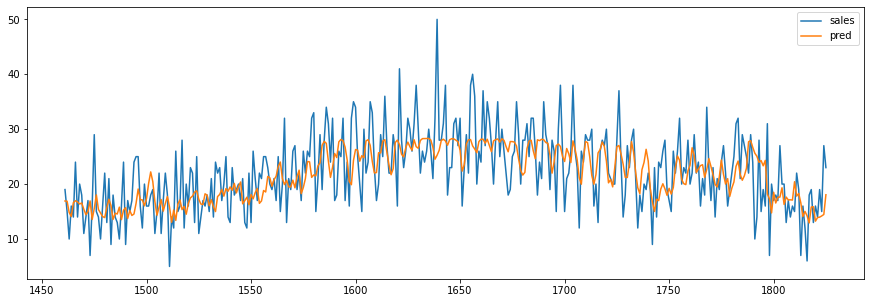

In [63]:
_ = Results_with_date_2017[['sales','pred']].plot(figsize=(15, 5))

In [65]:
Results_with_date_Jan_2017 =Results_with_date_2017[(New_Results.date<'2017-02-01')]

C:\Users\alexd\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


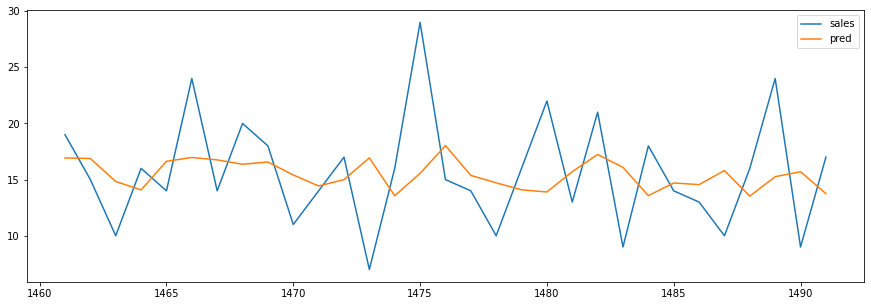

In [66]:
_ = Results_with_date_Jan_2017[['sales','pred']].plot(figsize=(15, 5))